In [1]:
import pandas as pd
import numpy as np
from sklearn.svm import OneClassSVM
from sklearn.metrics import precision_recall_fscore_support, confusion_matrix, classification_report
import seaborn as sns

In [2]:
dir_dados = '../2_dados/'
arq_treino_sumario = dir_dados + '/treino_teste/treino_sumario.parquet'
arq_treino = dir_dados + '/treino_teste/treino.npy'
arq_teste_sumario = dir_dados + '/treino_teste/teste_sumario.parquet'
arq_teste = dir_dados + '/treino_teste/teste.npy'

#### Abre arquivos

In [3]:
treino_idx = pd.read_parquet(arq_treino_sumario)    # Possui o target do treino
teste_idx = pd.read_parquet(arq_teste_sumario)      # Possui o target do teste

In [4]:
teste_idx['target'].value_counts()

0    140
1     35
Name: target, dtype: int64

In [5]:
treino = np.load(arq_treino)    # Todos da classe normal (0)
teste = np.load(arq_teste)      # 30% da classe normal (0), 100% das anomalias

In [6]:
print('Dimensão de Treino:', treino.shape)
print('Dimensão de Teste:', teste.shape)

Dimensão de Treino: (326, 800000)
Dimensão de Teste: (175, 800000)


In [7]:
# OneClassSVM utiliza a saída: -1 (normal) e 1 (anomalias)
y_true = teste_idx['target'].to_numpy()
y_true = np.where(y_true == 0, -1, 1)   # Troca 0 por -1

### OneClassSVM

In [8]:
def getOneClassSVMPred(nu=0.1, gamma=0.000005):
    svm = OneClassSVM(kernel='rbf', nu=nu, gamma=gamma)
    svm.fit(treino)
    y_pred = svm.predict(teste)
    metrics = precision_recall_fscore_support(y_true, y_pred, pos_label=1, average='binary')
    return svm, y_pred, metrics

In [9]:
svm, y_pred, metrics = getOneClassSVMPred(nu=0.1, gamma=0.000001)
print('Precisão:', round(metrics[0], 2))
print('Recall:', round(metrics[1], 2))
print('f1:', round(metrics[2], 2))

Precisão: 0.19
Recall: 0.8
f1: 0.31


In [10]:
cf_matrix = confusion_matrix(y_true, y_pred)
print(cf_matrix)

[[ 20 120]
 [  7  28]]


<AxesSubplot:>

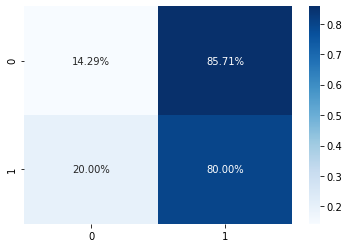

In [11]:
sns.heatmap(cf_matrix/cf_matrix.sum(axis=1)[:, np.newaxis], annot=True, fmt='.2%', cmap='Blues')

In [12]:
print(classification_report(y_true, y_pred, target_names=['Normal', 'Descarga Parcial']))

                  precision    recall  f1-score   support

          Normal       0.74      0.14      0.24       140
Descarga Parcial       0.19      0.80      0.31        35

        accuracy                           0.27       175
       macro avg       0.46      0.47      0.27       175
    weighted avg       0.63      0.27      0.25       175



#### Add Fase

In [13]:
fase = treino_idx['phase'].to_numpy().reshape(-1, 1)
treino = np.append(treino, fase, axis=1)

In [14]:
fase = teste_idx['phase'].to_numpy().reshape(-1, 1)
teste = np.append(teste, fase, axis=1)

In [15]:
svm, y_pred, metrics = getOneClassSVMPred(nu=0.05, gamma=0.00001)
print('Precisão:', round(metrics[0], 2))
print('Recall:', round(metrics[1], 2))
print('f1:', round(metrics[2], 2))

Precisão: 0.21
Recall: 0.77
f1: 0.34


In [16]:
cf_matrix = confusion_matrix(y_true, y_pred)
print(cf_matrix)

[[41 99]
 [ 8 27]]


<AxesSubplot:>

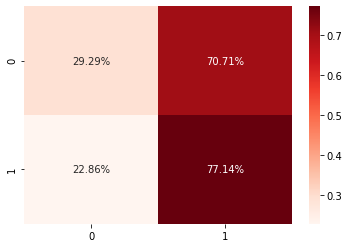

In [17]:
sns.heatmap(cf_matrix/cf_matrix.sum(axis=1)[:, np.newaxis], annot=True, fmt='.2%', cmap='Reds')

In [18]:
print(classification_report(y_true, y_pred, target_names=['Normal', 'Descarga Parcial']))

                  precision    recall  f1-score   support

          Normal       0.84      0.29      0.43       140
Descarga Parcial       0.21      0.77      0.34        35

        accuracy                           0.39       175
       macro avg       0.53      0.53      0.38       175
    weighted avg       0.71      0.39      0.41       175

